# Aggregation Methods Based on Legal Case-Based Reasoning

This notebook contains an implementation of the model presented in the paper "Aggregation Methods Based on Legal Case-Based Reasoning" by Ilaria Canavotto, John Horty, and Eric Pacuit

In [1]:
from enum import Enum, auto
import random
from itertools import chain, combinations, product
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
import seaborn as sns
import numpy as np
import pickle


## Helper Functions

In [2]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

## Side and Factor 

We assume that there are two sides 'Y' and 'N'.   Each factor favors one of the two sides.   

In [3]:
class Side(Enum):
    
    Y = 'Y'  # yes
    N = 'N'  # no
    
    def __str__(self):
        return str(self.value)

    @property
    def c(self): 
        '''
        The complement of the side
        '''
        return Side.Y if self == Side.N else Side.N
    
    def other(self): 
        '''
        The other side (this assumes that there are only two sides)
        '''
        return [member for s,member in Side.__members__.items() if s != self.value][0]

class Factor(object): 
    '''
    A factor consists of a name, the side it supports, and optionally a description.
    '''
    def __init__(self, name, side, description = None): 
        self.side = side
        self.name = name
        self.description = description
    
    def set_description(self, description):
        self.description = description
    
    def display(self): 
        return str(self.name) + ":" + str(self.side) + " - " + str(self.description)

    @classmethod
    def from_string(self, fstr):
        '''
        Create a factor from a string of the form "fname:side".
        '''
        fname, side = fstr.split(":")
        return Factor(fname, Side(side))
    
    def __str__(self): 
        return str(self.name) + ":" + str(self.side)
        
    def __eq__(self, other): 
        return self.side == other.side and self.name == other.name
    
    def __ne__(self, other): 
        return self.side != other.side or self.name != other.name
    
    def __hash__(self): 
        return hash(str(self.name) + ":" + str(self.side))
    

def factory(names_sides = None, num_Y = 0, num_N = 0):
    """
    Create a list of factors from a list of names for each side, and or the number of factors for each side.

    If num_Y > 0, then create factors f1, f2, ..., fnum_Y for side Y.
    If num_N > 0, then create factors g1, g2, ..., gnum_N for side N.
    """
    names_sides = names_sides if names_sides is not None else []
    for fname, side in names_sides:
        globals()[fname] =  Factor(fname, side)

    for i in range(num_Y):
        globals()["f" + str(i+1)] =  Factor("f" + str(i+1), Side.Y) 
    for i in range(num_N):
        globals()["g" + str(i+1)] =  Factor("g" + str(i+1), Side.N)


In [4]:
f_y = Factor('f', Side.Y)
f_n = Factor('f', Side.N)
print(f"{f_y} == {f_n} is ", f_y == f_n)

f2 = Factor.from_string("f2:N")
print(f2)
factory([('a', Side.Y), 
         ('b', Side.N), 
         ('c', Side.Y)], 
         num_Y=3, 
         num_N=3)
print(a)
print(b)
print(c)
print(f1)
print(f2)
print(f3)
print(g1)
print(g2)
print(g3)


f:Y == f:N is  False
f2:N
a:Y
b:N
c:Y
f1:Y
f2:Y
f3:Y
g1:N
g2:N
g3:N


## FactorSet

Both fact situations and reasons are sets of factors.   The following class contains the methods that is common to both.

In [5]:
class FactorSet(object): 
    
    def __init__(self, factors=None):
        """
        A FactorSet is a set of factors. Factors can be provided as a list of strings or Factor objects.
        """
        self.sides = list() # list of sides in the set of factors
        self.factors = set()
        if factors is not None:
            for factor in factors:
                self.add(factor)

    def add(self, factor):
        """
        Add a factor to the set, converting from string if necessary.
        """
        if isinstance(factor, str):
            factor = Factor.from_string(factor)
        elif not isinstance(factor, Factor):
            raise TypeError("factor must be a Factor instance or a string of the form 'fname:side'")
        self.factors.add(factor)

        if factor.side not in self.sides:
            self.sides.append(factor.side)
    
    def split(self): 
        """
        Return the factors in the set split by the side that they favor.
        """
        return {s: FactorSet([f for f in self.factors if f.side == s]) 
                for s in self.sides}
    
    def is_uniform(self):   
        """
        Return True if all the factors in the set favor the same side, or the set is empty.
        """
        return len(self.sides) <= 1
    
    def is_empty(self):
        """
        Return True if the set of factors is empty.
        """
        return len(self.factors) == 0
    
    def is_mixed(self):
        """
        Return True if the factors in the set favor different sides.
        """
        return len(self.sides) > 1
    
    def __eq__(self, other):
        """
        Return True of the factors in the two sets are the same.
        """
        if not isinstance(other, FactorSet):
            return NotImplemented
        return self.factors == other.factors

    def __le__(self, other):
        """
        Return True if the factors in this set are a strict subset of the factors in the other set.
        """
        if not isinstance(other, FactorSet):
            return NotImplemented
        return self.factors <= other.factors

    def __lt__(self, other):
        """
        Return True if the factors in this set are a strict subset of the factors in the other set.
        """
        if not isinstance(other, FactorSet):
            return NotImplemented
        return self.factors < other.factors

    def __ge__(self, other):
        """
        Return True if the factors in this set are a strict subset of the factors in the other set.
        """
        if not isinstance(other, FactorSet):
            return NotImplemented
        return self.factors >= other.factors

    def __gt__(self, other):
        """
        Return True if the factors in this set are a strict subset of the factors in the other set.
        """
        if not isinstance(other, FactorSet):
            return NotImplemented
        return self.factors > other.factors

    def __str__(self): 
        """
        Return True of the factors is a superset of the other factors.
        """   
        return "{" + ",".join([str(f) for f in self.factors])  + "}"

    def __iter__(self):
        return iter(self.factors)

    def __contains__(self, item):
        return item in self.factors

    def __len__(self):
        return len(self.factors)
    
    def __hash__(self): 
        return hash(tuple([str(f) for f in self.factors]))

    def __repr__(self):
        return f"FactorSet({self.factors})"


In [6]:
factory(num_Y=2, num_N=2)

fs1 = FactorSet()
fs1.add(f1)
fs1.add(g1)
print(fs1)

fs2 = FactorSet([f1, g1, g2])
print(fs2)

print(f"{fs1} == {fs2}: cx", fs1 == fs2)
print(f"{fs1} <= {fs2}: ", fs1 <= fs2)
print(f"{fs1} < {fs2}: ", fs1 < fs2)
print(f"{fs1} >= {fs2}: ", fs1 >=fs2)
print(f"{fs1} > {fs2}: ", fs1 > fs2)
print()
print(f"Sides for {fs1}: ", fs1.sides)
print(f"Splitting factors by side for {fs1}: ")
for s, factors in fs1.split().items():
    print(s,": ", factors)
print(f"{fs1} is uniform: ", fs1.is_uniform())

print(f"\nSides for {fs2}: ", fs2.sides)
print(f"Splitting factors by side for {fs2}: ")
for s, factors in fs2.split().items():
    print(s,": ", factors)
print(f"{fs2} is uniform: ", fs2.is_uniform())

print()
fs1 = FactorSet([g1, g2])
print(fs1)
print(f"{fs1} is uniform: ", fs1.is_uniform())

fs2 = FactorSet([f1, g1, g2])
print(fs2)
print(f"{fs2} is uniform: ", fs2.is_uniform())

print(f"{fs1} == {fs2}: cx", fs1 == fs2)
print(f"{fs1} <= {fs2}: ", fs1 <= fs2)
print(f"{fs1} < {fs2}: ", fs1 < fs2)
print(f"{fs1} >= {fs2}: ", fs1 >=fs2)
print(f"{fs1} > {fs2}: ", fs1 > fs2)

print()
print(f"len({fs2}): ", len(fs2))   
print(f"{f1} in {fs2}: ", f1 in fs2)
print(f"{f2} in {fs2}: ", f2 in fs2)
print(f"{f3} in {fs2}: ", f3 in fs2)
print(f"{g1} in {fs2}: ", g1 in fs2)
print(f"{g2} in {fs2}: ", g2 in fs2)
print(f"{g3} in {fs2}: ", g3 in fs2)

print("Iterating over factors in fs2:")
for f in fs2: 
    print(f)



{f1:Y,g1:N}
{g2:N,f1:Y,g1:N}
{f1:Y,g1:N} == {g2:N,f1:Y,g1:N}: cx False
{f1:Y,g1:N} <= {g2:N,f1:Y,g1:N}:  True
{f1:Y,g1:N} < {g2:N,f1:Y,g1:N}:  True
{f1:Y,g1:N} >= {g2:N,f1:Y,g1:N}:  False
{f1:Y,g1:N} > {g2:N,f1:Y,g1:N}:  False

Sides for {f1:Y,g1:N}:  [<Side.Y: 'Y'>, <Side.N: 'N'>]
Splitting factors by side for {f1:Y,g1:N}: 
Y :  {f1:Y}
N :  {g1:N}
{f1:Y,g1:N} is uniform:  False

Sides for {g2:N,f1:Y,g1:N}:  [<Side.Y: 'Y'>, <Side.N: 'N'>]
Splitting factors by side for {g2:N,f1:Y,g1:N}: 
Y :  {f1:Y}
N :  {g2:N,g1:N}
{g2:N,f1:Y,g1:N} is uniform:  False

{g2:N,g1:N}
{g2:N,g1:N} is uniform:  True
{g2:N,f1:Y,g1:N}
{g2:N,f1:Y,g1:N} is uniform:  False
{g2:N,g1:N} == {g2:N,f1:Y,g1:N}: cx False
{g2:N,g1:N} <= {g2:N,f1:Y,g1:N}:  True
{g2:N,g1:N} < {g2:N,f1:Y,g1:N}:  True
{g2:N,g1:N} >= {g2:N,f1:Y,g1:N}:  False
{g2:N,g1:N} > {g2:N,f1:Y,g1:N}:  False

len({g2:N,f1:Y,g1:N}):  3
f1:Y in {g2:N,f1:Y,g1:N}:  True
f2:Y in {g2:N,f1:Y,g1:N}:  False
f3:Y in {g2:N,f1:Y,g1:N}:  False
g1:N in {g2:N,f1:Y,g1:N}

## Fact Situations and Reasons

In [7]:
    
class Reason(FactorSet):
    """
    A reason is a set of factors all supporting the same side.
    """
    def __init__(self, factors=None, side=None):
        if isinstance(factors, FactorSet):
            # If factors is already a FactorSet, use its factors directly.
            super().__init__(factors=factors.factors)
        else:
            # Otherwise, pass whatever factors are provided (could be list of factors or strings).
            super().__init__(factors=factors)
        
        if not self.is_uniform(): 
            raise ValueError("All factors must support the same side to form a reason.")
        
        if not self.factors and side is None:
            raise ValueError("Side must be specified for an empty Reason.")

        # for the empty reason, the side must be set explicitly
        self.side = side if len(factors) == 0 else self.sides[0] 

        if side is not None and side != self.side: 
            raise ValueError(f"{side} does not match the side supported by all the factors.")
        
    def other_side(self): 
        return self.side.other()
        
    def subreasons(self, only_nonempty=True): 
        """
        Return all the subreasons of the current reason.

        If only_nonempty is True, then only return nonempty factors

        """
        return [Reason(fs, side=self.side) for fs in powerset(self.factors) 
                if not only_nonempty or len(fs) > 0]
            
    def __eq__(self, other):
        return self.side == other.side and super().__eq__(other)

    def __le__(self, other):
        return self.side == other.side and super().__le__(other)

    def __lt__(self, other):
        return self.__le__(other) and not self.__eq__(other)

    def __ge__(self, other):
        return self.side == other.side and super().__ge__(other)

    def __gt__(self, other):
        return self.__ge__(other) and not self.__eq__(other)

    def __str__(self): 
        return "{" + ",".join([str(f) for f in self.factors]) + "}" if len(self.factors) > 0 else  "{:" + str(self.side) + "}"
    
    def __hash__(self): 
        return hash(tuple([str(f) for f in self.factors])) if len(self.factors) > 0 else hash(tuple([f":{str(self.side)}"]))

class FactSit(FactorSet): 
    """
    Any set of factors can be a fact situation.
    """
    def __init__(self, factors = None): 
        super().__init__(factors)

    def supporting_factors(self, side): 
        """
        Return the set of factors that support the given side.
        """
        return FactorSet([f for f in self.factors if f.side == side])
    
    def holds(self, reason): 
        """
        Return True if the reason holds in the fact situation.
        """
        return self >= reason
    
    def reasons(self): 
        """
        Return all the reasons for the fact situation.
        """
        reason_for_Y = Reason(self.split()[Side.Y], side=Side.Y)
        reason_for_N = Reason(self.split()[Side.N], side=Side.N)
        return reason_for_Y.subreasons() + reason_for_N.subreasons()


In [8]:
r =  Reason([Factor(0, Side.Y), Factor(1, Side.Y)])
print(r)
r0 = Reason([], side=Side.Y)
print(r0)
r1 = Reason([Factor(0, Side.Y), Factor(1, Side.Y),  Factor(2, Side.Y)])
r2 = Reason([Factor(0, Side.N), Factor(1, Side.N)])
print(f"{r0} == {r} is {r0 == r}")
print(f"{r0} <= {r} is {r0 <= r}")
print(f"{r0} <= {r2} is {r0 <= r2}")
print(f"{r} <= {r1} is {r <= r1}")
print(f"{r} < {r1} is {r < r1}")
print(f"{r} == {r1} is {r == r1}")
print(f"{r} <= {r2} is {r <= r2}")

print(f"\nthe nonempty subreasons of {r1} are")
for sr in list(map(str,r1.subreasons())): 
    print(sr)

print(f"\nthe subreasons of {r1} are")
for sr in list(map(str,r1.subreasons(only_nonempty=False))): 
    print(sr)

fs = FactSit([Factor(0, Side.Y), Factor(1, Side.Y), Factor(2, Side.N)])
print("\nFact situation: ", fs)
print("Reasons in the fact situation: ")
for u in fs.reasons(): 
    print(u)

{1:Y,0:Y}
{:Y}
{:Y} == {1:Y,0:Y} is False
{:Y} <= {1:Y,0:Y} is True
{:Y} <= {1:N,0:N} is False
{1:Y,0:Y} <= {1:Y,2:Y,0:Y} is True
{1:Y,0:Y} < {1:Y,2:Y,0:Y} is True
{1:Y,0:Y} == {1:Y,2:Y,0:Y} is False
{1:Y,0:Y} <= {1:N,0:N} is False

the nonempty subreasons of {1:Y,2:Y,0:Y} are
{1:Y}
{2:Y}
{0:Y}
{1:Y,2:Y}
{1:Y,0:Y}
{2:Y,0:Y}
{1:Y,2:Y,0:Y}

the subreasons of {1:Y,2:Y,0:Y} are
{:Y}
{1:Y}
{2:Y}
{0:Y}
{1:Y,2:Y}
{1:Y,0:Y}
{2:Y,0:Y}
{1:Y,2:Y,0:Y}

Fact situation:  {2:N,1:Y,0:Y}
Reasons in the fact situation: 
{1:Y}
{0:Y}
{1:Y,0:Y}
{2:N}


## Preference

In [9]:
class Preference:
    def __init__(self, basic_prefs=None):
        """
        Initialize with a set of basic preferences between reasons.
        Each preference is a tuple (u, v) where u > v means 
        u is strictly preferred to v.
        """
        if basic_prefs is None:
            basic_prefs = []
        elif isinstance(basic_prefs, list):
            basic_prefs = [tuple(p) for p in basic_prefs]
        elif isinstance(basic_prefs, Preference):
            basic_prefs = basic_prefs.basic_prefs
        self.basic_prefs = basic_prefs

    def derived_prefers(self, u, v, include_basic_pref_reason=False):
        """
        Determines if u is preferred over v.
        
        Optionally returns the reason for this preference as a tuple (a, b) where a > b.
        """
        for a, b in self.basic_prefs:
            if u >= a and b >= v:
                return (True, (a, b)) if include_basic_pref_reason else True
        return (False, None) if include_basic_pref_reason else False

    def no_opinion(self, u, v):
        """
        Returns True if there is no preference between u and v.
        """
        return not self.derived_prefers(u, v) and not self.derived_prefers(v, u)

    def conditional_prefers(self, u, v, basic_prefs, include_basic_pref_reason=False):
        """
        Determines if u is preferred over v given additional basic preferences.
        
        Optionally returns the reason for this preference as a tuple (a, b) where a > b.
        """
        new_basic_prefs = basic_prefs.copy()
        for a, b in self.basic_prefs:
            if not any(b >= c and d >= a for c, d in basic_prefs):
                new_basic_prefs.append((a, b))

        for a, b in new_basic_prefs:
            if u >= a and b >= v:
                return (True, (a, b)) if include_basic_pref_reason else True
        return (False, None) if include_basic_pref_reason else False

    def add_basic_pref(self, u, v, allow_inconsistent_preference=False):
        """
        Adds a basic preference u > v.
        
        If allow_inconsistent_preference is False, it checks for inconsistencies before adding.
        """
        assert u.side != v.side, f"Preferences must be between reasons of different sides: {u} and {v}"
        
        if allow_inconsistent_preference: 
            self.basic_prefs.append((u, v))
        else:
            if not self.derived_prefers(v, u):
                self.basic_prefs.append((u, v))
                
    def has_basic_pref(self, a, b):
        """
        Checks if (a, b) is a basic preference.
        """
        return (a, b) in self.basic_prefs
    
    def reset(self):
        """
        Resets the basic preferences to an empty list.
        """
        self.basic_prefs = []

    def distance(self, other_preference):
        """
        Returns the distance to another preference based on the number of disagreements about the basic preferences.
        """
        return sum(self.derived_prefers(b, a) for a, b in other_preference.basic_prefs)
    
    def __str__(self):
        """
        Returns a string representation of the basic preferences.
        """
        return "\n".join([f"{a} > {b}" for a, b in self.basic_prefs])


In [10]:
r =  Reason([Factor(0, Side.Y), Factor(1, Side.Y)])
print(r)
r0 = Reason([], side=Side.Y)
print(r0)
r1 = Reason([Factor(0, Side.Y), Factor(1, Side.Y),  Factor(2, Side.Y)])
r2 = Reason([Factor(0, Side.N), Factor(1, Side.N)])

p = Preference()
p.add_basic_pref(r2, r)

p.derived_prefers(r1, r2, include_basic_pref_reason=True)


{1:Y,0:Y}
{:Y}


(False, None)

## Decision and DecisionSet

In [11]:
class Decision:
    def __init__(self, fact_situation, reason=None):
        self.fact_situation = fact_situation
        self.reason = reason

    @property
    def out(self):
        """
        The output of the decision.
        """
        return self.reason.side if self.reason is not None else None
    
    def set_reason(self, reason):
        """
        Set the reason for the decision.
        """
        if not self.fact_situation.holds(reason):
            raise ValueError("Reason must be a subset of the fact situation.")
        self.reason = reason

    def abstains(self):
        """
        Returns True if the decision abstains.
        """
        return self.reason is None
    
    def prefers(self, u, v):
        """
        Returns True if the decision generates the preference of u over v.
        """
        if not (self.fact_situation.holds(u) and self.fact_situation.holds(v)):
            return None
        return u.side == self.out and v.side == self.out.c and u >= self.reason and self.fact_situation >= v

    def basic_pref(self):
        """
        Returns the basic preference generated by the decision.
        """
        if self.reason is None:
            return None
        strongest_reason_other_side = Reason(self.fact_situation.supporting_factors(self.out.c), side=self.out.c)
        return (self.reason, strongest_reason_other_side)
    
    def __str__(self):
        return f"<{self.fact_situation}, {self.reason}, {self.out}>"
    
class DecisionSet:
    def __init__(self, decisions=None):
        self.decisions = decisions if decisions is not None else []

    def add(self, decision):
        """
        Add a decision to the set.
        """
        self.decisions.append(decision)

    def prefers(self, u, v):
        """
        Returns True if the decision set generates the preference of u over v.
        """
        return any(d.prefers(u, v) for d in self.decisions)
    
    def basic_preferences(self):
        """
        Returns the basic preferences generated by the decision set.
        """
        return [d.basic_pref() for d in self.decisions if d.reason is not None]

    def to_preference(self): 
        """
        Return the preference generated by the decision set.
        """
        return Preference([d.basic_pref() for d in self.decisions if d.reason is not None])

In [12]:
x = FactSit([f1, f2, g1, g2])
print(x)
dec = Decision(x)
dec.set_reason(Reason([f1]))
print(dec)

print(dec.prefers(Reason([f1, f2]), Reason([g1])))

print(dec.prefers(Reason([f1]), Reason([f2])))
print(dec.prefers(Reason([f1, f2]), Reason([f2])))
print(dec.prefers(Reason([f2]), Reason([f2])))
print(dec.prefers(Reason([f3]), Reason([g1])))

{g2:N,f1:Y,g1:N,f2:Y}
<{g2:N,f1:Y,g1:N,f2:Y}, {f1:Y}, Y>
True
False
False
False
None


## Voter, DecisionProfile, and Profile

In [13]:
    
class Voter(Preference):
    """
    A voter is a decision maker with a set of preferences.
    """
    def __init__(self, preference=None):
        super().__init__(preference)

    def prefers(self, u, v):
        """
        Returns True if the voter prefers u over v.
        """
        return self.derived_prefers(u, v)
    
    def conditional_prefers(self, u, v, basic_prefs, include_basic_pref_reason=False):
        """
        Determines if u is preferred over v given additional basic preferences.
        
        Optionally returns the reason for this preference as a tuple (a, b) where a > b.
        """
        return super().conditional_prefers(u, v, basic_prefs, include_basic_pref_reason)
    
    def decide(self, fact_situation, basic_prefs=None):
        """
        Make a decision based on the given fact situation and additional basic preferences.
        
        Parameters:
        - fact_situation: The situation to make a decision on.
        - basic_prefs: Additional basic preferences to constrain the decision.
        
        Returns:
        - A randomly chosen potential decision that is consistent with the voter's preferences.
        """
        basic_prefs = [] if basic_prefs is None else basic_prefs
        split_factors = fact_situation.split()  # Assuming split() returns a dictionary or similar structure
        factors_Y = split_factors[Side.Y]
        factors_N = split_factors[Side.N]

        reasons_Y = Reason(factors_Y, side=Side.Y)
        reasons_N = Reason(factors_N, side=Side.N)

        potential_reasons = []  # The potential reasons for the decision

        for r in reasons_Y.subreasons():
            if not self.conditional_prefers(reasons_N, r, basic_prefs):
                potential_reasons.append(r)

        for r in reasons_N.subreasons():
            if not self.conditional_prefers(reasons_Y, r, basic_prefs):
                potential_reasons.append(r)


        if len(potential_reasons) == 0:
            # This shouldn't happen!
            print("No decision is possible")
            print("Fact Situation:", fact_situation)
            print("Precedents:", [(str(bp[0]), str(bp[1])) for bp in basic_prefs])
            print("Preferences:", self)
            return None
        reason = random.choice(potential_reasons)
        
        return Decision(fact_situation, reason)

class DecisionProfile:
    def __init__(self, fact_situation, decisions=None):
        """
        Initialize the DecisionProfile with a fact situation and an optional list of decisions.
        """
        self.fact_situation = fact_situation
        self.decisions = decisions if decisions is not None else []

    def add(self, decision):
        """
        Add a decision to the profile.
        """
        self.decisions.append(decision)
    
    def num_support(self, side): 
        """
        Return the number of decisions supporting the given side.
        """
        return sum(1 for d in self.decisions if d.out == side)
    
    def num_oppose(self, side):
        """
        Return the number of decisions opposing the given side.
        """
        return sum(1 for d in self.decisions if d.out == side.c)
    
    def num_abstain(self):
        """
        Return the number of decisions that abstain.
        """
        return sum(1 for d in self.decisions if d.abstains())
    
    def majority_side(self, break_tie_randomly=True):
        """
        Return the side with the majority of decisions.
        """
        num_Y = self.num_support(Side.Y)
        num_N = self.num_support(Side.N)
        if num_Y > num_N:
            return Side.Y
        elif num_N > num_Y:
            return Side.N
        return random.choice([Side.Y, Side.N]) if break_tie_randomly else [Side.Y, Side.N]
    
    def majority_decisions(self):
        """
        Return the majority decisions in the profile.
        """
        maj_side = self.majority_side()
        return [d for d in self.decisions if d.out == maj_side]

    def weak_majority_decision(self):
        """
        Return the weak majority decision in the profile.
        """
        maj_side = self.majority_side()
        maj_decisions = [d for d in self.decisions if d.out == maj_side]
        
        weak_majority_reason = Reason(set(f for d in maj_decisions for f in d.reason.factors), side=maj_side)
        return Decision(self.fact_situation, weak_majority_reason)

class Profile:
    def __init__(self, voters=None): 
        """
        Initialize the Profile with an optional list of voters.
        """
        self.voters = voters if voters is not None else []

    def add(self, voter): 
        """
        Add a voter to the profile.
        """
        self.voters.append(voter)
    
    def choose_voter(self):
        """
        Randomly choose a voter from the profile.
        """
        return random.choice(self.voters)
    
    def to_decison_profile(self, fact_situation, basic_prefs=None):
        """
        Each voter makes a decision based on the fact situation and the basic preferences.
        
        Returns a DecisionProfile.
        """
        basic_prefs = [] if basic_prefs is None else basic_prefs
        decisions = []
        for voter in self.voters: 
            decision = voter.decide(fact_situation, basic_prefs=basic_prefs)    
            if decision is not None: 
                decisions.append(decision)
        return DecisionProfile(fact_situation, decisions=decisions)


## Figures 1 and 2

This section contains the code used to produce Figures 1 and 2 in the paper.

In [14]:
def generate_fact_situations(factors, only_mixed=True): 
    """
    Generate all possible fact situations from a list of factors.
    """
    
    return [FactSit(fs) for fs in powerset(factors) if not only_mixed or FactSit(fs).is_mixed()]

def generate_preference(reasons, pr_favor_y = 0.5, pr_abstain=0.0): 
    """
    Generate a preference between reasons.
    """

    reasons_for_Y = [r for r in reasons if r.side == Side.Y]
    reasons_for_N = [r for r in reasons if r.side == Side.N]

    np.random.shuffle(reasons_for_Y)
    np.random.shuffle(reasons_for_N)
    
    pref = Preference()
    for r_for_Y in reasons_for_Y: 
        if np.random.rand() < pr_abstain: 
            continue
        for r_for_N in reasons_for_N: 
            if not pref.derived_prefers(r_for_Y, r_for_N) and not pref.derived_prefers(r_for_N, r_for_Y): 
                if np.random.rand() < pr_favor_y: 
                    pref.add_basic_pref(r_for_Y, r_for_N)
                else: 
                    pref.add_basic_pref(r_for_N, r_for_Y)
    return pref

In [15]:
# import pickle
# factors = [f1, f2, f3, f4, g1, g2, g3, g4]
# fact_situations = generate_fact_situations(factors)
# print(len(fact_situations))

# num_trials = 10

# fact_situations_orders = []
# for t in tqdm(range(num_trials)): 
#     np.random.shuffle(fact_situations)
#     fact_situations_orders.append(fact_situations)

# pickle.dump(fact_situations_orders, open("fact_situations_orders.pkl", "wb"))

In [16]:
# num_profiles = 10
# num_voters = 5
# pr_abstain = 0.0

# for fs in fact_situations: 
#     for r in fs.reasons(): 
#         if r not in reasons:
#             reasons.append(r)

# profiles= []
# for _ in tqdm(range(num_profiles)): 
#     voters = [Voter(generate_preference(reasons, pr_abstain=pr_abstain)) for _ in range(num_voters)]
#     profiles.append(Profile(voters))
# pickle.dump(profiles, open("profiles.pkl", "wb"))   

In [17]:
SKIP_SIMULATION = True

if not SKIP_SIMULATION:
    data_for_df = {
        "num_trials": [],
        "trial": [],
        "num_factors": [],
        "num_voters": [],
        "pr_abstain": [],
        "group_decision_method": [],
        "avg_distance": [],
    }

    factors = [f1, f2, f3, f4, g1, g2, g3, g4]
    num_trials = 10
    num_voters = 5
    pr_abstain = 0.0    
    fact_situations_orders = pickle.load(open("fact_situations_orders.pkl", "rb"))
    profiles = pickle.load(open("profiles.pkl", "rb"))
    for profile in profiles: 
        for t in tqdm(range(num_trials)): 
            
            fact_situations = fact_situations_orders[t]
        
            # random dictatorship
            group_decisions = DecisionSet()

            for fs in fact_situations:  
                dec_prof = profile.to_decison_profile(fs, basic_prefs=group_decisions.basic_preferences())
                group_decisions.add(profile.choose_voter().decide(fs, basic_prefs=group_decisions.basic_preferences()))

            distances = [v.distance(group_decisions.to_preference()) for v in voters]

            data_for_df["num_trials"].append(num_trials)
            data_for_df["trial"].append(t)
            data_for_df["num_factors"].append(len(factors))
            data_for_df["num_voters"].append(num_voters)
            data_for_df["pr_abstain"].append(pr_abstain)
            data_for_df["group_decision_method"].append("random dictatorship")
            data_for_df["avg_distance"].append(np.average(distances))


            # weak majority decision
            group_decisions = DecisionSet()

            for fs in fact_situations:  
                dec_prof = profile.to_decison_profile(fs, basic_prefs=group_decisions.basic_preferences())
                group_decisions.add(dec_prof.weak_majority_decision())

            distances = [v.distance(group_decisions.to_preference()) for v in voters]

            data_for_df["num_trials"].append(num_trials)
            data_for_df["trial"].append(t)
            data_for_df["num_factors"].append(len(factors))
            data_for_df["num_voters"].append(num_voters)
            data_for_df["pr_abstain"].append(pr_abstain)
            data_for_df["group_decision_method"].append("weak majority decision")
            data_for_df["avg_distance"].append(np.average(distances))


            # majority decisions
            group_decisions = DecisionSet()

            for fs in fact_situations:  
                dec_prof = profile.to_decison_profile(fs, basic_prefs=group_decisions.basic_preferences())

                for d in dec_prof.majority_decisions():
                    group_decisions.add(d)

            distances = [v.distance(group_decisions.to_preference()) for v in voters]

            data_for_df["num_trials"].append(num_trials)
            data_for_df["trial"].append(t)
            data_for_df["num_factors"].append(len(factors))
            data_for_df["num_voters"].append(num_voters)
            data_for_df["pr_abstain"].append(pr_abstain)
            data_for_df["group_decision_method"].append("majority decision")
            data_for_df["avg_distance"].append(np.average(distances))


        df = pd.DataFrame(data_for_df)
        df.to_csv("data.csv")
else:
    print("Skipping simulation, reading data from files.")
    df_rd = pd.read_csv("data_rd.csv")
    df_mu = pd.read_csv("data_mu.csv")
    df_ma = pd.read_csv("data_ma.csv")
    df = pd.concat([df_rd, df_mu, df_ma])

Skipping simulation, reading data from files.


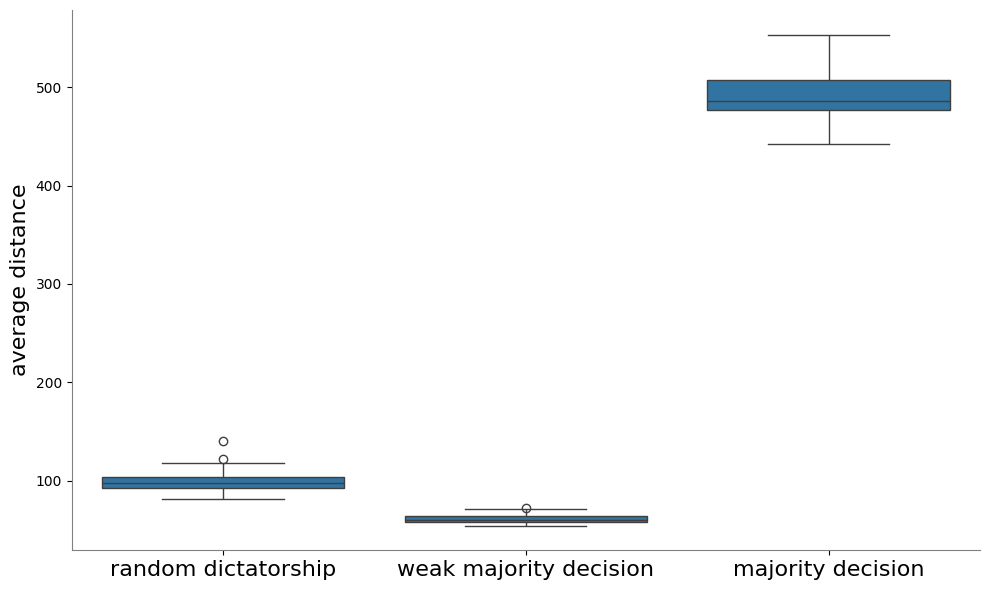

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
fontsize=16

# Create a box plot for the average distance by group decision method
plt.figure(figsize=(10, 6))
sns.boxplot(x='group_decision_method', y='avg_distance', data=df)
#sns.swarmplot(x='group_decision_method', y='avg_distance', data=df, color="black", alpha=0.75)

plt.title('')
plt.xlabel('', fontsize=fontsize)
plt.ylabel('average distance', fontsize=fontsize)
plt.xticks(rotation=0, fontsize=fontsize)

# make the x-axis and y-axis black
plt.gca().spines['bottom'].set_color('gray')
plt.gca().spines['left'].set_color('gray')
sns.despine()
plt.tight_layout()
plt.savefig('boxplot_avg_distance.pdf')
plt.show()


In [19]:
df = pd.concat([df_rd, df_mu])

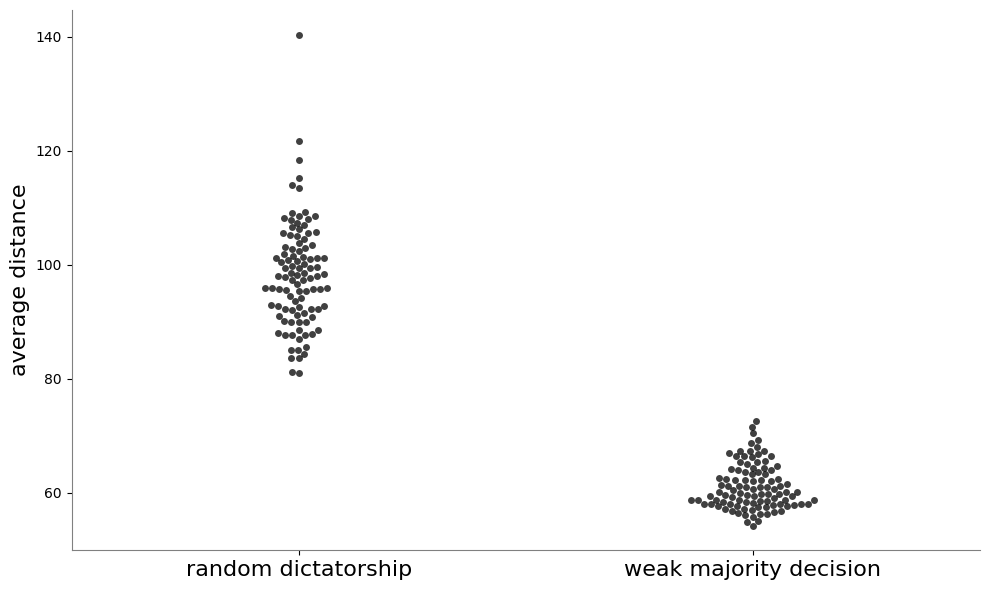

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
fontsize=16
# Create a box plot for the average distance by group decision method
plt.figure(figsize=(10, 6))
#sns.boxplot(x='group_decision_method', y='avg_distance', data=df)
sns.swarmplot(x='group_decision_method', y='avg_distance', data=df, color="black", alpha=0.75)

plt.title('')
plt.xlabel('')
plt.ylabel('average distance', fontsize=fontsize)
plt.xticks(rotation=0, fontsize=fontsize)

# make the x-axis and y-axis black
plt.gca().spines['bottom'].set_color('gray')
plt.gca().spines['left'].set_color('gray')
sns.despine()
plt.tight_layout()
plt.savefig('swarm_avg_distance.pdf')
plt.show()
